In [1]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
# from tqdm import tqdm
import medpy.metric as metric

import torch
import wandb

import monai
from monai.data import DataLoader, Dataset
from monai.transforms.utils import allow_missing_keys_mode
from monai.transforms import BatchInverseTransform
from monai.networks.nets import DynUNet

In [10]:
device = "cpu"
seed = 0

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
monai.utils.misc.set_determinism(seed, use_deterministic_algorithms=True)
torch.use_deterministic_algorithms(True)

In [2]:
def read_kits_data(dataset_path: str = "/dtu/3d-imaging-center/courses/02510/data/KiTS19") -> list[dict]:
    """ Assumes the data has quite specific structure. """
    return [
        {
            'image': str(path),                                                         # the unlabeled volume file, 'imaging.nii.gz'
            'label': str(path).replace("imaging.nii.gz", "segmentation_kidney.nii.gz"), # all the labeled data is named 'segmentation_kidney.nii.gz'
            'id': path.parent.name                                                      # the dir name, e.g. 'case_00000'
        }
        for path in sorted(Path(dataset_path).glob("*/imaging.nii.gz"))
    ]

In [12]:
def read_acd_data(dataset_path: str = "/dtu/3d-imaging-center/courses/02510/data/ACDC17") -> list[dict]:
    """ Assumes the data is in patient00X folders etc. """
    return [
        {
            'image': str(path),                                 # the unlabeled volume file
            'label': str(path).replace(".nii.gz", "_gt.nii.gz"),# all the labeled data has _gt in the path
            'id': path.name.split(".")[0]                       # the file name without ending 
        }
        for path in sorted(Path(dataset_path).glob("*/*frame[0-9][0-9].nii.gz"))
    ]

In [3]:
all_files = read_kits_data()
print(all_files[0])

{'image': '/dtu/3d-imaging-center/courses/02510/data/KiTS19/case_00000/imaging.nii.gz', 'label': '/dtu/3d-imaging-center/courses/02510/data/KiTS19/case_00000/segmentation_kidney.nii.gz', 'id': 'case_00000'}


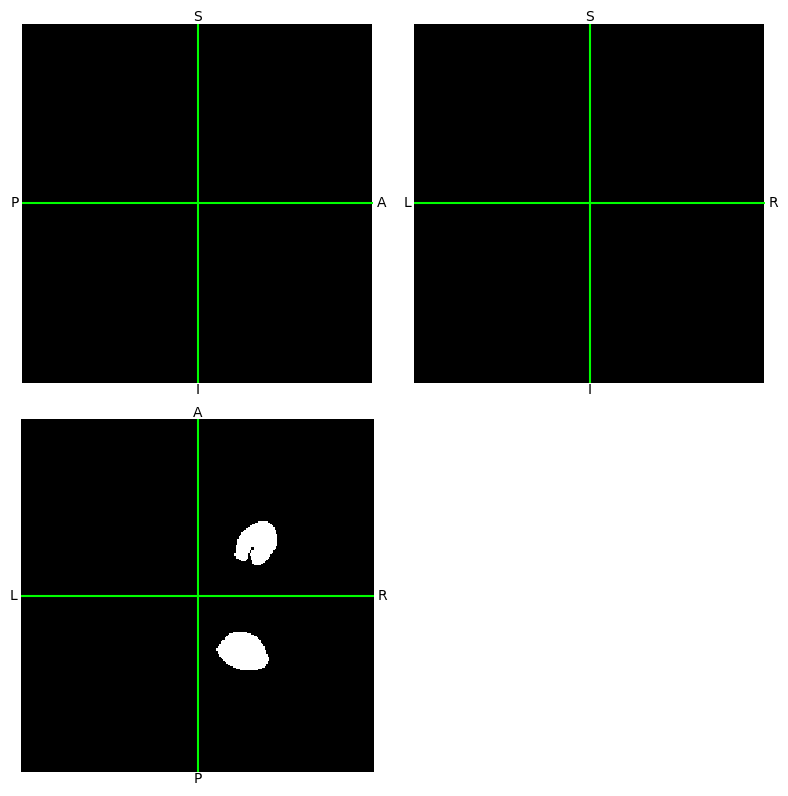

In [14]:
im = nib.load(all_files[0]['image'])
label = nib.load(all_files[0]['label'])
name = all_files[0]['id']

x, y, z = im.shape[0] // 2, im.shape[1] // 2, im.shape[2] // 2

plot = nib.viewers.OrthoSlicer3D(label.get_fdata(), title="Center slice of MRI data")
plot.set_position(x,y,z)
plt.tight_layout()
plot.show()

In [59]:
from torch.utils.data import random_split

# Get the (new) voxel size
# voxel_sizes = np.array([nib.load(file['image']).header.get_zooms() for file in all_files])
voxel_dims = 1.464845, 1.464845, 10.0 # np.median(voxel_sizes, axis=0)

n_classes = 2
im_dims = 256, 256,-1 #TODO: Should be defined further up
batch_size = 4 # TODO: Batch size >= 1 doesnt work for some reason

transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.Spacingd(keys=['image', 'label'], pixdim=voxel_dims, mode=["bilinear", "nearest"]),
    monai.transforms.ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=im_dims),
    monai.transforms.RandSpatialCropd(keys=['image', 'label'], roi_size=[-1, -1, 1]),
    # monai.transforms.SqueezeDimd(keys=['image', 'label'], dim=-1), # TODO: This doesn't work for some reason

    # TODO: (Light) data augmentation

    # monai.transforms.AsDiscreted(keys=['label'], to_onehot=n_classes) # Convert "label" to onehot encoded.
])

full_dataset = Dataset(data=all_files, transform=transforms)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, lengths = [0.7, 0.1, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=1, shuffle=False) 
test_dataloader  = DataLoader(test_dataset, batch_size=1, shuffle=False) 

In [60]:
def count_parameters(model): 
    """ Get the number of params in a model. See: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = DynUNet(
    spatial_dims = 2,   # 2 for 2D convolutions, 3 for 3D convolutions
    in_channels  = 1,   # Number of input channels/modalities (3 for RGB)
    out_channels = n_classes,   # Number of classes, including background
    kernel_size  = [3, 3, 3, 3, 3, 3], # Size of the filters
    strides      = [1, 2, 2, 2, 2, 2],
    upsample_kernel_size = [2, 2, 2, 2, 2]
).to(device)

print(f"Num params: {count_parameters(model):_}")

Num params: 20_611_170


## Training

In [71]:
loss_fn = monai.losses.DiceLoss(softmax=True, to_onehot_y=False) # Apply "softmax" to the output of the network and don't convert to onehot because this is done already by the transforms.
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
inferer = monai.inferers.SliceInferer(roi_size=[-1, -1], spatial_dim=2, sw_batch_size=1)

with torch.no_grad():  # Do not need gradients for this part
    for batch in val_dataloader:
        x = batch['image'].to(device).squeeze(dim = -1) # TODO: This squeeze has to be here because monai.transforms.SqueezeDimd gives error
        y = batch['label'].to(device).squeeze(dim = -1) # TODO: This squeeze has to be here because monai.transforms.SqueezeDimd gives error
        
        print(x.shape, y.shape)
        pred = model(x)
        print(pred.shape)
        # print(pred.shape)
        # prediction = inferer(inputs=x, network=model)
        print(pred.max())
        # print(metric.dc(pred.argmax(dim=1), y))
        print(metric.dc(torch.ones_like(y), y))
        break

torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
metatensor(13.6934)
0.004202576362030636


In [17]:
if torch.count_nonzero(torch.ones(1, 2, 256, 256, dtype=torch.int32)):
    print("NJKNASJKD")

NJKNASJKD


In [10]:
# torch.Size([1, 2, 256, 256]) torch.Size([1, 2, 256, 256])
metric.binary.hd95(torch.zeros(1, 2, 256, 256, dtype=torch.int32).numpy(), torch.ones(1, 2, 256, 256, dtype=torch.int32).numpy())

RuntimeError: The first supplied array does not contain any binary object.

In [194]:
lr = 1e-3
n_epochs = 3

loss_fn = monai.losses.DiceLoss(softmax=True, to_onehot_y=False) # Apply "softmax" to the output of the network and don't convert to onehot because this is done already by the transforms.
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
inferer = monai.inferers.SliceInferer(roi_size=[-1, -1], spatial_dim=2, sw_batch_size=1)

iterations = 0

for epoch in range(n_epochs):
    print(f"**** Epoch {epoch+1}/{n_epochs} ****")

    training_loss = 0.0
    validation_loss = 0.0

    # Train
    model.train()
    for batch_num, batch in enumerate(train_dataloader):
        x = batch['image'].to(device)
        y = batch['label'].to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        training_loss += loss

        if (iterations % config.wandb.train_log_interval == config.wandb.train_log_interval - 1):
            print(f"{batch_num + 1}/{len(train_dataloader)} | loss: {loss:.3f}")
            wandb.log({
                "epoch" : epoch,
                "iteration" : iterations,
                "batch/train" : batch_num,
                "loss/train"  : training_loss.item() / (batch_num + 1),
            })
        
        iterations += 1


    
    # Validate
    model.eval()
    with torch.no_grad():
        for batch_num, batch in enumerate(val_dataloader):
            x = batch['image'].to(device)
            y = batch['label'].to(device)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            validation_loss += loss

            if (batch_num % config.wandb.validation_log_interval == config.wandb.validation_log_interval - 1):
                print(f"{batch_num + 1}/{len(val_dataloader)} | val loss: {loss.item():.3f}")
                wandb.log({
                    "epoch" : epoch,
                    "batch/val" : batch_num,
                    "loss/val": validation_loss.item() / (batch_num + 1),
                })


    
    # Logging
wandb.finish()

**** Epoch 1/3 ****


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 256, 256, 28]

## Plot results

37.5


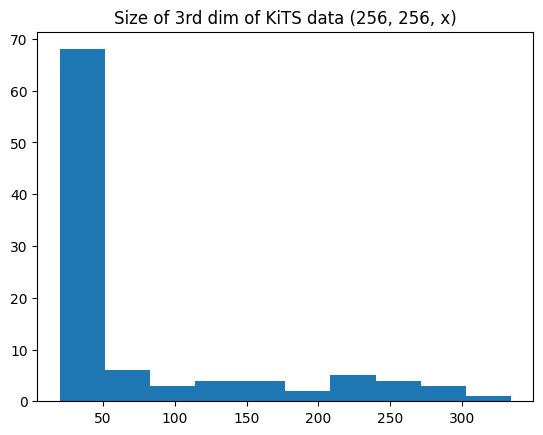

In [12]:
imageDims = np.array([nib.load(file['image']).header.get_data_shape() for file in all_files])

print(np.median(imageDims[:,2]))

plt.hist(imageDims[:,2])
plt.title("Size of 3rd dim of KiTS data (256, 256, x)")
plt.show()